# Experimentación - DCRNN



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import DCRNNModel
from utils.trainer import  TrainerDCRNN
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [36]:
def entrenar_y_evaluar_modelos_dcrnn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]


    for hidden_size in tqdm(list(param_grid["hidden_size"])):
        

        model = DCRNNModel(name="DCRNN", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_dim=hidden_size, is_classification=True)
        device =  torch.device("cpu")
        print(f"Entrenando modelo con hidden_size={hidden_size}")
        model.to(device)
        trainer = TrainerDCRNN(model, dataset, device, f"./results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Hidden": hidden_size,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {"hidden": hidden_size}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden_size)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [37]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import DCRNNModel

In [38]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerDCRNN

In [39]:

param_grid = {
    "hidden_size": [10,20,40,60]
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": False
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_dcrnn(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "DCRNN",target_names)

  0%|          | 0/4 [00:00<?, ?it/s]

Entrenando modelo con hidden_size=10

==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5969 | Eval Loss: 1.5742 | Accuracy: 0.5067 | Precision: 0.1913 | Recall: 0.3286 | F1-Score: 0.2415 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5858 | Eval Loss: 1.5643 | Accuracy: 0.5200 | Precision: 0.1971 | Recall: 0.3429 | F1-Score: 0.2503 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.5792 | Eval Loss: 1.5588 | Accuracy: 0.5067 | Precision: 0.1955 | Recall: 0.3286 | F1-Score: 0.2440 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.5750 | Eval Loss: 1.5545 | Accuracy: 0.5067 | Precision: 0.1955 | Recall: 0.3286 | F1-Score: 0.2440 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.5711 | Eval Loss: 1.5487 | Accuracy: 0.5067 | Precision: 0.1931 | Recall: 0.3286 | F1-Score: 0.2426 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 1.5669 | Eval Loss: 1.5445 | Accuracy: 0.4933 | 

 25%|██▌       | 1/4 [01:12<03:37, 72.44s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  torch.Size([])
test loss: 1.469520, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  10
Resultados:  {'Hidden': 10, 'Loss_final': 1.461032748222351, 'Accuracy_eval': 0.4556410256410256, 'Precision_eval': 0.20978667035381576, 'Recall_eval': 0.2739010989010989, 'F1_eval': 0.19881225337981479, 'Loss_eval': 1.422240972518921, 'Loss_tst': 1.469519853591919, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685, 'Recall_tst': 0.383

 50%|█████     | 2/4 [03:34<03:47, 113.58s/it]

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.49        84
   macro avg       0.21      0.40      0.27        84
weighted avg       0.24      0.49      0.32        84

preds:  torch.Size([])
test loss: 1.421145, test accuracy: 0.4881, test precision: 0.2063, test recall: 0.4000, test F1-score: 0.2715
Parámetros:  20
Resultados:  {'Hidden': 20, 'Loss_final': 1.3890777826309204, 'Accuracy_eval': 0.5115384615384616, 'Precision_eval': 0.27063924754467517, 'Recall_eval': 0.3337912087912087, 'F1_eval': 0.26777368669324675, 'Loss_eval': 1.3601421117782593, 'Loss_tst': 1.4211453199386597, 'Accuracy_tst': 0.4880952380952381, 'Precision_tst': 0.20634920634920634, 'Recall_tst': 0.4

 75%|███████▌  | 3/4 [07:07<02:38, 158.69s/it]

              precision    recall  f1-score   support

           0       0.58      0.92      0.71        12
           1       0.38      0.73      0.50        15
           2       0.50      0.11      0.18         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.52      0.43        84
weighted avg       0.45      0.56      0.47        84

preds:  torch.Size([])
test loss: 1.368665, test accuracy: 0.5595, test precision: 0.4328, test recall: 0.5177, test F1-score: 0.4307
Parámetros:  40
Resultados:  {'Hidden': 40, 'Loss_final': 1.3070194721221924, 'Accuracy_eval': 0.5617948717948719, 'Precision_eval': 0.27061180807150903, 'Recall_eval': 0.4064816218264493, 'F1_eval': 0.31113983264915146, 'Loss_eval': 1.3040797710418701, 'Loss_tst': 1.3686654567718506, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.4328280132379631, 'Recall_tst': 0.51

100%|██████████| 4/4 [10:56<00:00, 164.10s/it]

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  torch.Size([])
test loss: 1.365779, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899
Parámetros:  60
Resultados:  {'Hidden': 60, 'Loss_final': 1.285657286643982, 'Accuracy_eval': 0.5671794871794873, 'Precision_eval': 0.296720335828573, 'Recall_eval': 0.4341625615763546, 'F1_eval': 0.3398514456547805, 'Loss_eval': 1.2970181703567505, 'Loss_tst': 1.3657785654067993, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.32703853955375256, 'Recall_tst': 0.49551


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  torch.Size([])
test loss: 1.365779, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899


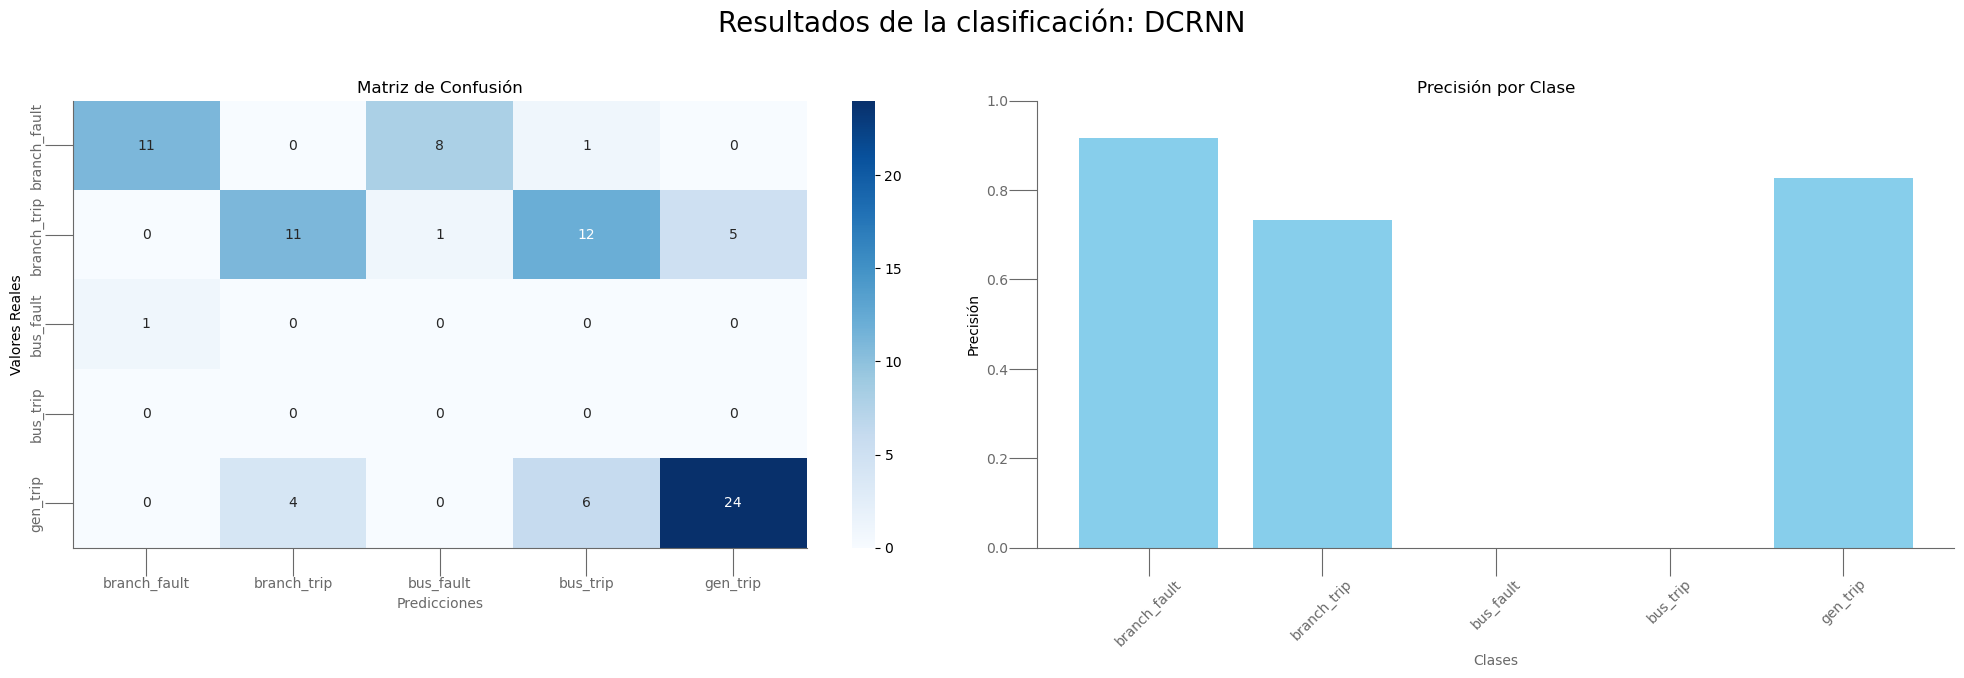

In [42]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "DCRNN")

In [43]:
name_model ="DCRNN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0     MPNN_LSTM                {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH                  {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH                  {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN             {'hidden': 50, 'Embedding': 5, 'K': 2}   
4   DyGrEncoder  {'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_o...   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_...   
6         DCRNN                                     {'hidden': 60}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841   
3  ../experimentos_split/results/clasificacion/aj...  1.344170   1.